# Inference with Propensity Score

## Import Libraries

In [1]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scipy.stats
from scipy.special import expit

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression

## Data Generation

In [2]:
n = 200

In [3]:
x_1 = np.random.randint(15, 76, n)
x_2 = np.random.randint(0, 2, n)

let the DGP of Z be defined as follows:

$Z_{i} = \phi (\frac{a_{i}}{10})$

where $\phi (x) = \frac{1}{1+e^{-x}}$

and $a_{i}=x_{1i}+10x_{2i}-40+u_{i}$

In [4]:
def dgp_Z(x_1, x_2, n):
    
    u = np.random.randn(n) * 5
    a = x_1 + (10 * x_2) - 40 + u
    z = expit(0.1 * a)
    
    Z = np.array([])
    for i in range(n):
        Z_i = np.random.choice(2, size=1, p=[1 - z[i], z[i]])[0]
        Z = np.append(Z, Z_i)
    
    return Z

In [5]:
Z = dgp_Z(x_1, x_2, n)

let the DGP of Y be defined as follows:

$y_{i}=-x_{1i}+30x_{2i}+\beta_{z} Z-80+u_{i}$

In [6]:
def dgp_Y(x_1, x_2, beta_z, Z, n):
    
    u = np.random.randn(n) * 10
    Y = -x_1 + (30 * x_2) + (beta_z * Z) + 80 + u
    
    return Y

now, let $\beta_{z} = 10$

In [7]:
Y = dgp_Y(x_1, x_2, 10, Z, n)

In [8]:
df = pd.DataFrame({
    'X_1': x_1,
    'X_2': x_2,
    'Z': Z,
    'Y': Y,
})

In [9]:
df

,X_1,X_2,Z,Y
0,64,0,1.0,25.590035
1,53,0,1.0,45.892019
2,39,1,0.0,68.862074
3,38,1,1.0,80.656668
4,73,1,1.0,19.855713
...,...,...,...,...
195,38,0,1.0,33.354356
196,73,1,1.0,49.732772
197,31,1,0.0,69.594624
198,68,1,1.0,42.992042


## (1) Mere Comparison of Means (Bad!)

In [10]:
df.groupby('Z').mean()

,X_1,X_2,Y
Z,,,
0.0,30.573529,0.529412,62.66460
1.0,51.340909,0.583333,55.66603


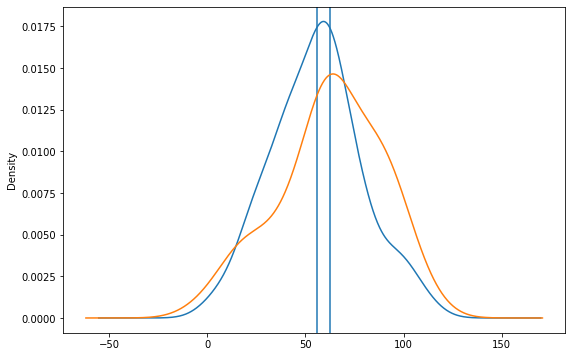

In [11]:
for _z in df.Z.unique():
    _df = df[df.Z == _z].Y
    plt.axvline(x=_df.mean())
    _df.plot.kde(figsize=(9,6))

In [12]:
df[df.Z == 1].Y.mean() - df[df.Z == 0].Y.mean()

-6.998570207808889

## (2) w/ OLS

In [13]:
data = sm.add_constant(df)
endog = data['Y']
exog = data[['X_1', 'X_2', 'Z', 'const']]

In [14]:
model = sm.OLS(endog=endog, exog=exog)
result = model.fit()

In [15]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     329.8
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           2.60e-76
Time:                        23:05:00   Log-Likelihood:                -741.64
No. Observations:                 200   AIC:                             1491.
Df Residuals:                     196   BIC:                             1504.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X_1           -0.9969      0.048    -20.585      0.0

In [16]:
result.params['Z']

12.126276428388106

## (3) ATE w/ IPTW (Inverse Probability of Treatment Weighting)

In [17]:
data = sm.add_constant(df)
endog = data['Z']
exog = data[['X_1', 'X_2', 'const']]

In [18]:
# model = sm.Logit(endog=endog, exog=exog)
model = sm.GLM(endog=endog, exog=exog, family=sm.families.Binomial())
result = model.fit(disp=0)

In [19]:
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Z   No. Observations:                  200
Model:                            GLM   Df Residuals:                      197
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -91.610
Date:                Mon, 01 Mar 2021   Deviance:                       183.22
Time:                        23:05:03   Pearson chi2:                     216.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X_1            0.0906      0.013      6.866      0.0

### Propensity Score

In [20]:
p_score = result.predict()

In [21]:
p_score[:10]

array([0.92353444, 0.81684609, 0.68901443, 0.66928391, 0.97966396,
       0.85406259, 0.8678782 , 0.82054682, 0.53409937, 0.84569034])

In [22]:
p_score[:10].round(0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Compute ATE

In [23]:
ATE_i = (data.Y / p_score * data.Z) - (data.Y / (1 - p_score) * (1 - data.Z))
ATE_i.mean()

10.325836871027636

## (4) ATE w/ Doubly Robust Estimation

In [24]:
data = df.copy()
model = LinearRegression().fit(
    data[['X_1', 'X_2', 'Z']],
    data['Y']
)

In [25]:
Y_0 = model.predict(
    data
    .assign(Z=np.zeros(len(data)))
    .drop(columns='Y')
)
Y_1 = model.predict(
    data
    .assign(Z=np.ones(len(data)))
    .drop(columns='Y')
)

In [26]:
model = LogisticRegression().fit(
    data[['X_1', 'X_2']],
    data['Z']
)

### Propensity Score

In [27]:
p_score = model.predict_proba(data[['X_1', 'X_2']])

In [28]:
p_score[:5]

array([[0.07447042, 0.92552958],
       [0.1782904 , 0.8217096 ],
       [0.31771831, 0.68228169],
       [0.33758019, 0.66241981],
       [0.02123937, 0.97876063]])

### Compute ATE

In [29]:
ATE_1_i = data.Y / p_score[:, 1] * data.Z + (1 - data.Z / p_score[:, 1]) * Y_1
ATE_0_i = data.Y / p_score[:, 0] * (1 - data.Z) + (1 - (1 - data.Z) / p_score[:, 0]) * Y_0

In [30]:
(ATE_1_i - ATE_0_i).mean()

10.608259431533472